# Netgen-Poreflow
**Simulating fluid flow inporous media using Poreflow and Netgen porenetwork modeling package**

###### Author : Misagh Esmaeilpour (misagh@ksu.edu)

###### Semester: Spring 2020

---

A brief overview of what the following code snippets aim to do is provided <a href="https://raw.githubusercontent.com/misagh-esmaeilpour/netgen-poreflow/master/proposal.md" title="proposal">here</a>.

The package that we are using for our simulations was developed by Per Valvatne [1] which is written in C++ and you can <a href="http://www.imperial.ac.uk/earth-science/research/research-groups/perm/research/pore-scale-modelling/software/two-phase-network-modelling-code/" title="download_link"> download</a> all the executable files and manuals directly from the website of Imperial College London.

"netgen_32.exe" is the executable file that generates our porenetworks. This file gets a *.dat file as an input. This input file consist of all the properties that we want to assign to our porenetworks such as network size, length of pore throats, etc. In our simulation this file is "netgenInput.dat" and since we want to change network size of porenetworks in our simulations we have to create a new "netgenInput.dat" file each time we change this parameter.    ######## output files of it 4.dat

"poreflow_32.exe" is the executable file that simulates fluid flow through our generated porenetwork and it gets a *.dat file as an input too, which would be "poreflowInput.dat" in our simulations. This input file consists of all the properties that we want to assign to our fluid and flow mechanism. In our study all these properties are constant and therefore we will use our pre-written "poreflowInput.dat" for all the simulations.  ########### 3 output filesss

**Note:** If you need to modify your "poreflowInput.dat" for your simulations, you could easily follow the same steps that we have done to modify "netgenInput.dat" and add it to your code.

After running "poreflow_32.exe" all the results will be saved as texts in a .prt file. Therefore we will read this files and extract our desired values which would be permeability, porosity and formation factor.


In [130]:
#importing required modules
import os
import numpy as np
import matplotlib.pyplot as plt
import datetime
from numba import jit


First we define a list of the network sizes that we want to simulate and number of iterations for each of the networks.
By network size we mean that how many pores we have in each of the three primary directions. For instance a network of size 10, is a cubic porenetwork that has 10 * 10 * 10 = 1000 pores in it.

%%%%%%%%%%% maybe put a pic here of a pnm

At the code snippet below we have also defined the three arrays that will store all of our desired vaules out of simulations.

In [131]:
starttime= datetime.datetime.now()

networks_sizes = [10, 20] # A list of network sizes for simulations
iteration = 2 # Number of iterations
# Defining three arrays to store simulation data:
permeability_array = np.zeros((len(networks_sizes),len(range(iteration))))
formationfactor_array = np.zeros((len(networks_sizes),len(range(iteration))))
porosity_array = np.zeros((len(networks_sizes),len(range(iteration))))

The only parameter that is changed in the "netgenInput.dat" is network size.
This lambda function will allow us to change network. Its input argument would be an string like "20 20 20".

In [139]:
net_input = lambda network : ["Porenetworks % Base file \n",
        network,"\n",
        "0.1 10 0.2 6 % Min throat radius, max throat radius, delta exp, eta exp \n",
        "100 100 0.3 2.0 % Min throat length, max throat length, delta exp, eta exp \n",
        "0 0 0.2 3.0 % Min aspect ratio, max aspect ratio, delta exp, eta exp \n",
        "0.001 0.04811 0.8 1.6 % Triangles: Min G, max G, delta exp, eta exp \n",
        "0 1 % Pores: proportion of square and circular pores \n",
        "0 1 % Throats: proportion of square and circular throats \n",
        "0 % Proportion of pore volume occupied by clay \n",
        "6 % Average connection number <= 6 \n",
        "T % Use periodic boundary conditions \n"]

In the following code snippet, we generate the the input file for "netgen_32.exe" and write it into "netgenInput.dat". And then will generate porenetworks and right after that simulationg the flow through them starts.
Our values of interest would be saved in a .prt (poreflowInput.prt) file that  "preflow_32.exe" outputs. And we can easily read these values from this file.
Based on experience working with this package we know that porosity, permeability, and formation factor would saved respectively on either lines 22, 25, and 26 or 30, 33, and 34. Also sometimes because of the heavy computations poreflow crashes and will not output anythin. Hence, we handle all three scenarios in the code below.

In [140]:
## questino: should I find the number of lines by code or this is good??
# formationfactor?

for i in range(len(networks_sizes)):
    for j in range(iteration):
        #network_3d = str(networks_sizes[i])+ " " +str(networks_sizes[i])+ " "+ str(networks_sizes[i])
        network_3d= (str(networks_sizes[i])+ " ")*3
        input_text= net_input(network_3d)
        
        # writing input_text in 'netgenInput.dat'
        f= open("netgenInput.dat","w")
        f.writelines(input_text)
        f.close()
        
        # generating pore networks
        os.system("netgen_win32.exe netgenInput.dat")
        # simulating flow through generated porenetworks
        os.system("poreflow_win32.exe poreflowInput.dat")

        output = open("poreflowInput.prt")
        output_lines = output.readlines()
        
        if len(output_lines) < 26:
            permeability_array[i][j] = np.nan
            porosity_array[i][j] = np.nan
            formationfactor_array[i][j] = np.nan
            
        elif "permeability" in output_lines[25].split():
            permeability_line = output_lines[25].split()
            permeability_array[i][j] = permeability_line[-1]

            porosity_line = output_lines[22].split()
            porosity_array[i][j] = porosity_line[-1]

            formationfactor_line = output_lines[26].split()
            formationfactor_array[i][j] = formationfactor_line[-1]
        else:
            permeability_line = output_lines[33].split()
            permeability_array[i][j] = permeability_line[-1]

            porosity_line = output_lines[30].split()
            porosity_array[i][j] = porosity_line[-1]

            formationfactor_line = output_lines[34].split()
            formationfactor_array[i][j] = formationfactor_line[-1]


After storing the desired values of all iterations in our arrays, we get a mean value of all iterations per network size.

In [134]:
permeability_means = np.nanmean(permeability_array, axis=1)
formationfactor_means = np.nanmean(formationfactor_array, axis=1)
porosity_means = np.nanmean(porosity_array, axis=1)

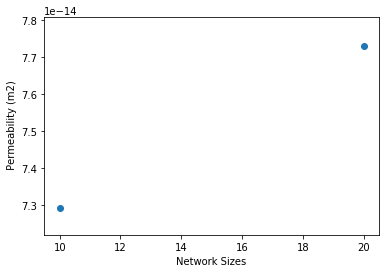

In [135]:
# What is the best way to set the ylim? I did it as you see below but not too happy with it. 

plt.scatter(networks_sizes, permeability_means, )
plt.xlabel('Network Sizes')
plt.ylabel(' Permeability (m2)')
# I set mt y axis this way
plt.ylim(0.99*min(permeability_means), 1.01*max(permeability_means))
plt.show()

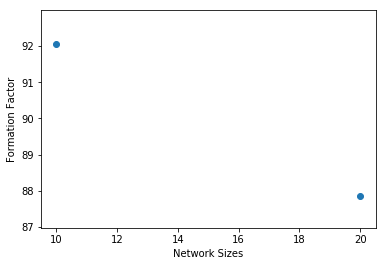

In [136]:
plt.scatter(networks_sizes, formationfactor_means)
plt.xlabel('Network Sizes')
plt.ylabel('Formation Factor')
plt.ylim(0.99*min(formationfactor_means), 1.01*max(formationfactor_means))
plt.show()


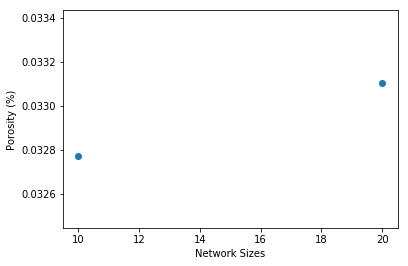

In [137]:
plt.scatter(networks_sizes, porosity_means)
plt.xlabel('Network Sizes')
plt.ylabel('Porosity (%)')
plt.ylim(0.99*min(porosity_means), 1.01*max(porosity_means))
plt.show()

In [138]:
endtime= datetime.datetime.now()
endtime -starttime

datetime.timedelta(seconds=63, microseconds=932687)

In [ ]:
# Matlab took around 4200 seconds